**Deep Comment Toxicity Model**

In [2]:
#Importing necessary libraries
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
#Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/CommentToxicity/CTds.csv')

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df[['toxic' ,'severe_toxic' ,'obscene' ,'threat' ,'insult' ,'identity_hate']].sum()

toxic            15296
severe_toxic      1596
obscene           8449
threat             479
insult            7877
identity_hate     1407
dtype: int64

### **Preprocessing**

In [ ]:
import spacy
import re
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
import html

In [ ]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))

def to_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def replace_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_whitespaces(text):
    return text.strip()

def remove_stopwords(words, stop_words):
    return [word for word in words if word not in stop_words]

def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def text2words(text):
    return word_tokenize(text)

def clean_text( text):
    text = remove_special_chars(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    words = lemmatize_words(words)

    return ''.join(words)

df['comment_text'] = df['comment_text'].apply(lambda x: clean_text(x))

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edit make username hardcore metall...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww match background colour im seemingly stic...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really try edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestion improvement wonder s...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0


In [ ]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
#Number of words in the vocabulary
MAX_FEATURES = 200000 

In [ ]:
#Converting text into numerical
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [ ]:
vectorizer.adapt(X.values)

In [ ]:
vectorized_text = vectorizer(X.values)

In [ ]:
# map, chache, shuffle, batch, prefetch 
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [ ]:
#Train test validation split
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

### **Model Building**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
#Sequential model
model = Sequential()
#Embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
#Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
#Feature extractor Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

#Output layer 
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 256)               16640     
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                      

In [ ]:
history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15
6981/6981 [==============================] - 497s 70ms/step - loss: 0.0612 - val_loss: 0.0457
Epoch 2/15
6981/6981 [==============================] - 487s 70ms/step - loss: 0.0448 - val_loss: 0.0391
Epoch 3/15
6981/6981 [==============================] - 488s 70ms/step - loss: 0.0400 - val_loss: 0.0349
Epoch 4/15
6981/6981 [==============================] - 487s 70ms/step - loss: 0.0354 - val_loss: 0.0303
Epoch 5/15
6981/6981 [==============================] - 490s 70ms/step - loss: 0.0321 - val_loss: 0.0273
Epoch 6/15
6981/6981 [==============================] - 492s 70ms/step - loss: 0.0288 - val_loss: 0.0255
Epoch 7/15
6981/6981 [==============================] - 490s 70ms/step - loss: 0.0263 - val_loss: 0.0227
Epoch 8/15
6981/6981 [==============================] - 493s 71ms/step - loss: 0.0241 - val_loss: 0.0204
Epoch 9/15
6981/6981 [==============================] - 492s 70ms/step - loss: 0.0211 - val_loss: 0.0190
Epoch 10/15
6981/6981 [==============================] 

In [ ]:
model.save('CT.h5')

<Figure size 576x360 with 0 Axes>

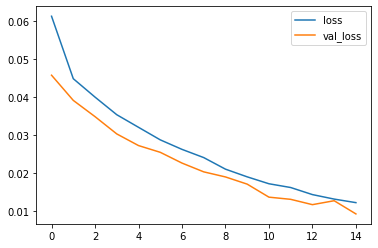

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

### **Predictions**

In [ ]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [ ]:
input_text.shape

TensorShape([1800])

In [ ]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 667ms/step


In [ ]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 157ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
res.shape

(1, 6)

### **Model Evaluation**

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    #Batch unpacking 
    X_true, y_true = batch
    #Making predictions 
    yhat = model.predict(X_true)
    #Flattening the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 38ms/step


In [3]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9637386798858643, Recall:0.9300150871276855, Accuracy:0.9015647220611572


### **Testing and Gradio**

In [4]:
#!pip install gradio jinja2

In [4]:
import tensorflow as tf
import gradio as gr

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/CommentToxicity/CT.h5')

In [ ]:
input_str = vectorizer('hey i freaken hate you!')

In [ ]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 648ms/step


In [ ]:
res

array([[0.7928624 , 0.00162167, 0.03158484, 0.01254913, 0.16159621,
        0.0271233 ]], dtype=float32)

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [ ]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [ ]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4d8207eb-fef0-4b1e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
